In [75]:
import os
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

### Initialise the environment

In [151]:
p1 = 0.75 # reward proba for arm 1
p2 = 0.2 # reward proba for arm 2

arms = [p1, p2]

### Initialise the agent

In [152]:
def policy(q_values, temp=None):

    if temp:
        t = temp
    else:
        t = 1
    return np.exp(q_values*t)/np.sum(np.exp(q_values*t))

def belief_update(M_curr, arm, rew):

    M_next = M_curr.copy()
    if rew == 1:
        M_next[arm, 0] += 1
    else:
        M_next[arm, 1] += 1
    return M_next

gamma   = 0.9
gittins = np.genfromtxt('../gittins100_gamma09.csv', delimiter=',')
gittins = gittins[1:, 1:] # remove (0, .) and (., 0) priors

### Run the model-free agent

In [153]:
np.random.seed(1234)

# initial belief state
M = np.array([
    [1, 1],
    [1, 1]
], dtype=int)

num_episodes = 80
for ep in range(num_episodes):
    Q  = np.array([gittins[M[0, 0], M[0, 1]], gittins[M[1, 0], M[1, 1]]])
    # a = np.argmax(Q)
    ps = policy(Q)
    a  = np.random.choice([0, 1], p=ps)
    r  = np.random.choice([0, 1], p=(1-arms[a], arms[a]))
    M  = belief_update(M, a, r)

### Plot the resulting belief

Text(0.5, 1.0, '$\\mathbb{E}[p\\mid b]$')

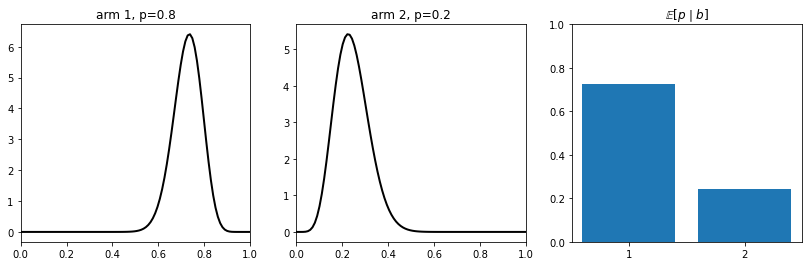

In [154]:
plt.figure(figsize=(14, 4))

x = np.linspace(0, 1, 100)
plt.subplot(1, 3, 1)
a, b = M[0, 0], M[0, 1]
rv = beta(a, b)
plt.plot(x, rv.pdf(x), 'k-', lw=2)
plt.xlim(0,1)
plt.title('arm 1, p=%.1f'%arms[0])
plt.subplot(1, 3, 2)
a, b = M[1, 0], M[1, 1]
rv = beta(a, b)
plt.plot(x, rv.pdf(x), 'k-', lw=2)
plt.xlim(0,1)
plt.title('arm 2, p=%.1f'%arms[1])
plt.subplot(1, 3, 3)
plt.bar([1, 2], [M[0, 0]/np.sum(M[0, :]), M[1, 0]/np.sum(M[1, :])])
plt.xticks([1, 2], [1, 2])
plt.ylim(0,1)
plt.title(r'$\mathbb{E}[p\mid b]$')

In [155]:
M

array([[37, 14],
       [ 8, 25]])

### Construct belief tree

In [156]:
def get_belief_tree(h, b):

    # initialise the hyperstate tree
    tree = {hi:{} for hi in range(h)}
    
    tree[0][(0)] = b

    for hi in range(1, h):
        c = 0
        for k, v in tree[hi-1].items():
            
            if hi == 1:
                prev_c = 0
            else:
                prev_c = k[-1]
            
            for a in range(2):
                for r in [0, 1]:

                    b1 = belief_update(v, a, r)
                                            
                    tree[hi][(a, prev_c, c)] = b1
                    c += 1
    return tree

### Replay in belief tree

We want to prioritise updates in this belief tree. The prioritisation scheme is the following:

$$
\begin{align*}
v(b')-v(b)=&\sum_a\big[ ( \pi(a\mid b')-\pi(a\mid b) )q(b', a)\big]\\
&+\mathbb{E}_{\pi(a\mid b)}\big[r(b',a) - r(b,a)\big]\\ 
&+\mathbb{E}_{\pi(a\mid b)}\big[\gamma \sum_{b''}p(b''\mid b', a)v(b'') - \gamma \sum_{b'}p(b'\mid b, a)v(b') \big]
\end{align*}
$$

where the policy $\pi(a\mid b)$ is determined by the Gittins index associated with belief $b$, $q(b', a)$ is the Gittins index, and $v(b')=\mathbb{E}_{\pi(a\mid b')}\big[q(b',a)\big]$

For the moment, we will only consider single-step updates from children to their parents

In [157]:
def evb(b, b_prime):

    q = np.array([gittins[b[0, 0], b[0, 1]], gittins[b[1, 0], b[1, 1]]])
    q_prime = np.array([gittins[b_prime[0, 0], b_prime[0, 1]], gittins[b_prime[1, 0], b_prime[1, 1]]])

    probs = policy(q)
    probs_prime = policy(q_prime)

    gain = np.dot(probs_prime - probs, q_prime)

    tmp_rew = np.array([b[0, 0]/np.sum(b[0, :]), b[1, 0]/np.sum(b[1, :])])
    tmp_rew_prime = np.array([b_prime[0, 0]/np.sum(b_prime[0, :]), b_prime[1, 0]/np.sum(b_prime[1, :])])

    rew = np.dot(probs, (tmp_rew_prime - tmp_rew))

    b_prime00 = belief_update(b, 0, 0)
    b_prime01 = belief_update(b, 0, 1)
    b_prime10 = belief_update(b, 1, 0)
    b_prime11 = belief_update(b, 1, 1)

    q_prime00 = np.array([gittins[b_prime00[0, 0], b_prime00[0, 1]], gittins[b_prime00[1, 0], b_prime00[1, 1]]])
    q_prime01 = np.array([gittins[b_prime01[0, 0], b_prime01[0, 1]], gittins[b_prime01[1, 0], b_prime01[1, 1]]])
    q_prime10 = np.array([gittins[b_prime10[0, 0], b_prime10[0, 1]], gittins[b_prime10[1, 0], b_prime10[1, 1]]])
    q_prime11 = np.array([gittins[b_prime11[0, 0], b_prime11[0, 1]], gittins[b_prime11[1, 0], b_prime11[1, 1]]])

    b_prime_prime00 = belief_update(b_prime, 0, 0)
    b_prime_prime01 = belief_update(b_prime, 0, 1)
    b_prime_prime10 = belief_update(b_prime, 1, 0)
    b_prime_prime11 = belief_update(b_prime, 1, 1)

    q_prime_prime00 = np.array([gittins[b_prime_prime00[0, 0], b_prime_prime00[0, 1]], gittins[b_prime_prime00[1, 0], b_prime_prime00[1, 1]]])
    q_prime_prime01 = np.array([gittins[b_prime_prime01[0, 0], b_prime_prime01[0, 1]], gittins[b_prime_prime01[1, 0], b_prime_prime01[1, 1]]])
    q_prime_prime10 = np.array([gittins[b_prime_prime10[0, 0], b_prime_prime10[0, 1]], gittins[b_prime_prime10[1, 0], b_prime_prime10[1, 1]]])
    q_prime_prime11 = np.array([gittins[b_prime_prime11[0, 0], b_prime_prime11[0, 1]], gittins[b_prime_prime11[1, 0], b_prime_prime11[1, 1]]])

    v_prime0 = (b[0, 0]/np.sum(b[0, :]))*np.dot(policy(q_prime00), q_prime00) + (b[0, 1]/np.sum(b[0, :]))*np.dot(policy(q_prime01), q_prime01)
    v_prime1 = (b[1, 0]/np.sum(b[1, :]))*np.dot(policy(q_prime10), q_prime10) + (b[1, 1]/np.sum(b[1, :]))*np.dot(policy(q_prime11), q_prime11)
    
    v_prime_prime0 = (b_prime[0, 0]/np.sum(b_prime[0, :]))*np.dot(policy(q_prime_prime00), q_prime_prime00) + (b_prime[0, 1]/np.sum(b_prime[0, :]))*np.dot(policy(q_prime_prime01), q_prime_prime01)
    v_prime_prime1 = (b_prime[1, 0]/np.sum(b_prime[1, :]))*np.dot(policy(q_prime_prime10), q_prime_prime10) + (b_prime[1, 1]/np.sum(b_prime[1, :]))*np.dot(policy(q_prime_prime11), q_prime_prime11)

    nxt = gamma*(np.dot(probs, np.array([v_prime0, v_prime1])) + np.dot(probs, np.array([v_prime_prime0, v_prime_prime1]))) 

    return gain + rew + nxt

In [159]:
h    = 6
tree = get_belief_tree(h, M)

In [160]:
evb_tree = {hi:{} for hi in range(h)}
for hi in reversed(range(h-1)):
    for k, v in tree[hi].items():
        if hi == 0:
            c = 0
        else:
            c = k[-1]
        for k1, v1 in tree[hi+1].items():
            a = k1[0]
            prev_c = k1[-2]
            if prev_c == c:
                evb_tree[hi][(a, k1[-1])] = [evb(v, v1), v, v1]

### Check updates with the highest evb

In [161]:
updates = {hi:[] for hi in range(h)}
for hi in reversed(range(h-1)):
    max_val = 0
    for k, v in evb_tree[hi].items():
        if v[0] > max_val:
            updates[hi] = v
            max_val     = v[0]


In [162]:
updates

{0: [9.875454198828213e-01,
  array([[37, 14],
         [ 8, 25]]),
  array([[37, 14],
         [ 9, 25]])],
 1: [0.9981783992225802,
  array([[37, 14],
         [ 9, 25]]),
  array([[37, 14],
         [10, 25]])],
 2: [1.0084886648281552,
  array([[37, 14],
         [10, 25]]),
  array([[37, 14],
         [11, 25]])],
 3: [1.0184787461349243,
  array([[37, 14],
         [11, 25]]),
  array([[37, 14],
         [12, 25]])],
 4: [1.0281780765714963,
  array([[37, 14],
         [12, 25]]),
  array([[37, 14],
         [13, 25]])],
 5: []}